In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
MODEL_NAME = "./lora-distilbert-imdb"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): lora.Linear(
              (base_layer): Linear(in_features=768, out_features=768, bias=True)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.05, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=768, out_features=8, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=8, out_features=768, b

In [7]:
dataset = load_dataset("imdb")
test_data = dataset["test"]

label_names = ["negative", "positive"]

In [8]:
def predict_batch(text_list):
    enc = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**enc)
        preds = torch.argmax(outputs.logits, dim=1)

    return preds.cpu().numpy()

In [9]:
all_texts = test_data["text"]
all_labels = test_data["label"]

predictions = []
batch_size = 32

for i in range(0, len(all_texts), batch_size):
    batch = all_texts[i:i+batch_size]
    preds = predict_batch(batch)
    predictions.extend(preds)

predictions = np.array(predictions)

In [10]:
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions, average="macro")
recall = recall_score(all_labels, predictions, average="macro")
f1 = f1_score(all_labels, predictions, average="macro")

print("=== Metrics ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-Score (macro):  {f1:.4f}")

print("\n=== Classification Report ===")
print(classification_report(all_labels, predictions, target_names=label_names))

=== Metrics ===
Accuracy:  0.9086
Precision (macro): 0.9092
Recall (macro):    0.9086
F1-Score (macro):  0.9085

=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.92      0.89      0.91     12500
    positive       0.89      0.93      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000



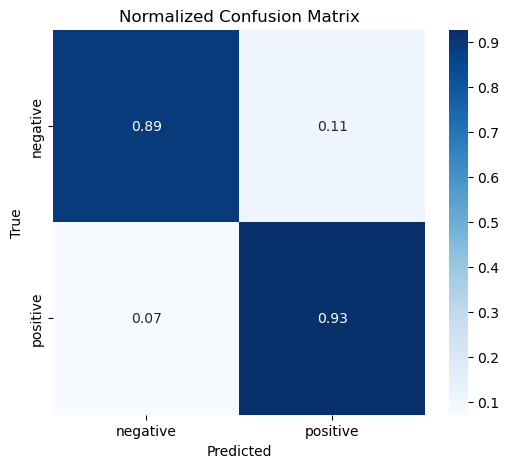

In [11]:
cm = confusion_matrix(all_labels, predictions, normalize="true")

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
    fmt=".2f"
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
report = classification_report(
    all_labels, predictions,
    target_names=label_names,
    output_dict=True
)

f1_neg = report["negative"]["f1-score"]
f1_pos = report["positive"]["f1-score"]

if f1_neg < f1_pos:
    worst_class = 0
else:
    worst_class = 1

print(f"\nWorst performing class: {label_names[worst_class]}")


Worst performing class: negative


In [13]:
misclassified_indices = [
    i for i, (true, pred) in enumerate(zip(all_labels, predictions))
    if true == worst_class and pred != worst_class
]

print(f"Found {len(misclassified_indices)} misclassified samples.")

Found 1383 misclassified samples.


In [22]:
for idx in misclassified_indices[5:7]:
    print("\n--- Misclassified Example ---")
    print(f"True label: {label_names[all_labels[idx]]}")
    print(f"Predicted:  {label_names[predictions[idx]]}")
    print("Text:")
    print(all_texts[idx])


--- Misclassified Example ---
True label: negative
Predicted:  positive
Text:
The only reason this movie is not given a 1 (awful) vote is that the acting of both Ida Lupino and Robert Ryan is superb. Ida Lupino who is lovely, as usual, becomes increasingly distraught as she tries various means to rid herself of a madman. Robert Ryan is terrifying as the menacing stranger whose character, guided only by his disturbed mind, changes from one minute to the next. Seemingly simple and docile, suddenly he becomes clever and threatening. Ms. Lupino's character was in more danger from that house she lived in and her own stupidity than by anyone who came along. She could not manage to get out of her of her own house: windows didn't open, both front and back doors locked and unlocked from the inside with a key. You could not have designed a worse fire-trap if you tried. She did not take the precaution of having even one extra key. Nor could she figure out how to summon help from nearby neighbors